In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import gymnasium as gym
from gymnasium import spaces
import random
from collections import deque
import re
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import seaborn as sns

Exercice 1: Préparation des données

In [2]:
# Chargement des données
df = pd.read_csv('../Data/fake_job_postings.csv')
print(f"Forme du dataset: {df.shape}")

Forme du dataset: (17880, 18)


In [4]:
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [7]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [8]:
print(f"\nDistribution des classes:")
print(df['fraudulent'].value_counts())
print(f"Pourcentage de fausses offres: {df['fraudulent'].mean()*100:.2f}%")



Distribution des classes:
fraudulent
0    17014
1      866
Name: count, dtype: int64
Pourcentage de fausses offres: 4.84%


C:\Windows\Temp\ipykernel_22432\1308809941.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='fraudulent', data=df, palette='viridis')


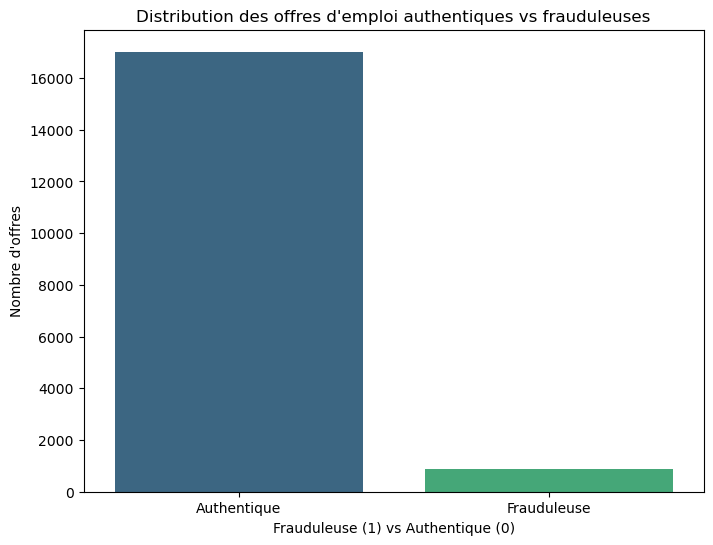

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='fraudulent', data=df, palette='viridis')
plt.title('Distribution des offres d\'emploi authentiques vs frauduleuses')
plt.xlabel('Frauduleuse (1) vs Authentique (0)')
plt.ylabel('Nombre d\'offres')
plt.xticks([0, 1], ['Authentique', 'Frauduleuse'])
plt.show()

Préparation du texte

In [11]:
df['title'] = df['title'].fillna('')
df['description'] = df['description'].fillna('')
df['text'] = df['title'] + ' ' + df['description']


Nettoyage du texte

In [12]:
def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)  # Suppression des balises HTML
    text = re.sub(r'[^A-Za-z0-9\s]', ' ', text)  # Suppression des caractères spéciaux
    text = re.sub(r'\s+', ' ', text)  # Normalisation des espaces
    return text.lower().strip()

In [13]:
df['text'] = df['text'].apply(clean_text)

In [14]:
print("\nExemple de texte nettoyé:")
print(df['text'].iloc[0][:300] + "...")


Exemple de texte nettoyé:
marketing intern food52 a fast growing james beard award winning online food community and crowd sourced and curated recipe hub is currently interviewing full and part time unpaid interns to work in a small team of editors executives and developers in its new york city headquarters reproducing and o...


Vectorisation du texte

In [15]:
print("\nVectorisation du texte avec TF-IDF...")
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['text']).toarray()
y = df['fraudulent'].values


Vectorisation du texte avec TF-IDF...


Division train/test

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Dimensions X_train: {X_train.shape}")
print(f"Dimensions X_test: {X_test.shape}")

Dimensions X_train: (14304, 5000)
Dimensions X_test: (3576, 5000)


Visualisation des mots les plus importants

In [17]:
def plot_top_tfidf_words(vectorizer, n=20):
    """Visualise les mots avec les scores TF-IDF les plus élevés"""
    feature_names = vectorizer.get_feature_names_out()
    tfidf_mean = np.mean(X, axis=0)
    
    # Tri des indices par score moyen
    sorted_indices = np.argsort(tfidf_mean)[::-1]
    top_indices = sorted_indices[:n]
    
    plt.figure(figsize=(12, 8))
    plt.barh(range(n), tfidf_mean[top_indices], align='center')
    plt.yticks(range(n), [feature_names[i] for i in top_indices])
    plt.xlabel('Score TF-IDF moyen')
    plt.title(f'Top {n} mots avec les scores TF-IDF les plus élevés')
    plt.tight_layout()
    plt.show()

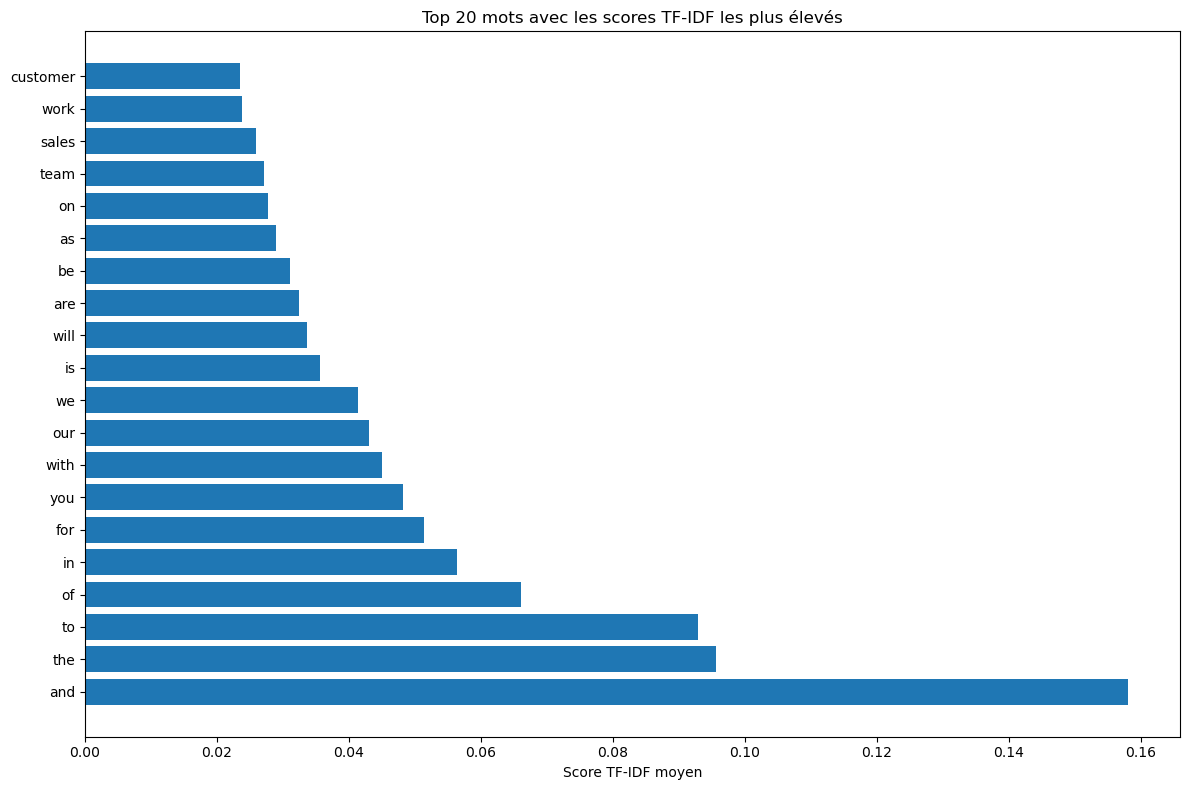

In [18]:
plot_top_tfidf_words(vectorizer)

Modélisation en Environnement RL
   - Exercice 2: Modélisation en Environnement RL

In [19]:
class JobClassificationEnv(gym.Env):
    """
    Environnement personnalisé pour la classification des offres d'emploi
    - État: vecteur TF-IDF d'une offre d'emploi
    - Actions: 0 (authentique) ou 1 (frauduleuse)
    - Récompense: +1 si classification correcte, -1 sinon
    - Un seul pas par épisode (one-step)
    """
    metadata = {"render_modes": ["human"]}
    
    def __init__(self, features, labels):
        super(JobClassificationEnv, self).__init__()
        self.features = features
        self.labels = labels
        self.current_index = 0
        self.current_state = None
        
        # Définition des espaces d'observation et d'action
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(features.shape[1],), 
            dtype=np.float32
        )
        self.action_space = spaces.Discrete(2)  # 0 = authentique, 1 = frauduleuse
        
    def reset(self, seed=None, options=None):
        """Réinitialise l'environnement avec un nouvel exemple aléatoire"""
        # Gestion correcte du seed selon l'API Gymnasium
        if seed is not None:
            super().reset(seed=seed)
            
        if options is None:
            options = {}
            
        # Sélection aléatoire d'un exemple
        self.current_index = random.randint(0, len(self.features) - 1)
        self.current_state = self.features[self.current_index].astype(np.float32)
        
        # Retourne l'état et un dictionnaire info vide conformément à l'API Gymnasium
        return self.current_state, {}
    
    def step(self, action):
        """Exécute une action et retourne résultat, récompense, etc."""
        # Calcul de la récompense
        reward = 1.0 if action == self.labels[self.current_index] else -1.0
        
        # Un seul pas par épisode
        done = True
        truncated = False
        info = {}
        
        return self.current_state, reward, done, truncated, info
    
    def render(self, mode="human"):
        """Visualisation de l'environnement (non implémentée)"""
        pass

Création des environnements d'entraînement et de test

In [20]:
train_env = JobClassificationEnv(X_train, y_train)
test_env = JobClassificationEnv(X_test, y_test)

In [21]:
print(f"Dimension de l'espace d'observation: {train_env.observation_space.shape}")
print(f"Nombre d'actions possibles: {train_env.action_space.n}")


Dimension de l'espace d'observation: (5000,)
Nombre d'actions possibles: 2


- Exercice 3: Création du modèle DQN et entraînement

In [22]:
class DQN(nn.Module):
    """Réseau de neurones pour l'apprentissage Q (Deep Q-Network)"""
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        
        # Amélioration: Initialisation des poids pour une meilleure convergence
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [24]:
class DQNAgent:
    """Agent utilisant un DQN avec replay memory et exploration epsilon-greedy"""
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)  # Mémoire de replay
        self.gamma = 0.95  # Facteur d'actualisation
        self.epsilon = 1.0  # Taux d'exploration initial
        self.epsilon_min = 0.01  # Taux d'exploration minimal
        self.epsilon_decay = 0.995  # Taux de décroissance de l'exploration
        self.learning_rate = 0.001  # Taux d'apprentissage
        
        # Initialisation du modèle, de l'optimiseur et de la fonction de perte
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        
        # Tracking des métriques pour visualisation
        self.losses = []
        self.rewards = []
        self.epsilons = []
    
    def remember(self, state, action, reward, next_state, done):
        """Stocke une expérience dans la mémoire de replay"""
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        """Choisit une action selon la politique epsilon-greedy"""
        if np.random.rand() <= self.epsilon:
            # Exploration: action aléatoire
            return random.randrange(self.action_size)
        
        # Exploitation: meilleure action selon le modèle
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            act_values = self.model(state_tensor)
            return torch.argmax(act_values[0]).item()
    
    def replay(self, batch_size):
        """Entraîne le modèle sur un mini-batch d'expériences"""
        if len(self.memory) < batch_size:
            return 0  # Pas assez d'expériences
        
        # Échantillonnage aléatoire d'un mini-batch
        minibatch = random.sample(self.memory, batch_size)
        total_loss = 0
        
        for state, action, reward, next_state, done in minibatch:
            # Conversion des données en tenseurs PyTorch
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            
            # Calcul de la cible Q
            target = reward
            if not done:
                with torch.no_grad():
                    target = reward + self.gamma * torch.max(self.model(next_state_tensor)[0]).item()
            
            # Prédiction actuelle
            current_q = self.model(state_tensor)[0]
            target_f = current_q.clone()
            target_f[action] = target
            
            # Mise à jour du modèle
            self.optimizer.zero_grad()
            loss = self.criterion(current_q, target_f)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
        
        # Mise à jour du taux d'exploration
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        avg_loss = total_loss / batch_size
        self.losses.append(avg_loss)
        return avg_loss
    
    def plot_metrics(self):
        """Visualise les métriques d'entraînement"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        # Plot des pertes
        ax1.plot(self.losses)
        ax1.set_title('Évolution de la perte pendant l\'entraînement')
        ax1.set_xlabel('Mini-batch')
        ax1.set_ylabel('Perte (MSE)')
        ax1.grid(True)
        
        # Plot des récompenses et epsilon
        ax2.plot(self.epsilons, label='Epsilon')
        if self.rewards:
            # Lissage des récompenses pour une meilleure lisibilité
            window_size = min(50, len(self.rewards))
            smoothed_rewards = np.convolve(self.rewards, np.ones(window_size)/window_size, mode='valid')
            ax2.plot(smoothed_rewards, label='Récompense moyenne (lissée)')
        
        ax2.set_title('Évolution de l\'exploration et des récompenses')
        ax2.set_xlabel('Épisode')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def load(self, name):
        """Charge un modèle pré-entraîné"""
        self.model.load_state_dict(torch.load(name))
    
    def save(self, name):
        """Sauvegarde le modèle"""
        torch.save(self.model.state_dict(), name)

Initialisation de l'agent

In [25]:
state_size = X_train.shape[1]
action_size = 2
agent = DQNAgent(state_size, action_size)

Paramètres d'entraînement

In [26]:
batch_size = 32
EPISODES = 1000
episode_rewards = []

In [27]:
print(f"Nombre d'épisodes: {EPISODES}")
print(f"Taille du batch: {batch_size}")


Nombre d'épisodes: 1000
Taille du batch: 32


Boucle d'entraînement

In [28]:
for e in range(EPISODES):
    # Réinitialisation de l'environnement
    state, _ = train_env.reset()
    done = False
    episode_reward = 0
    
    # Boucle d'un épisode
    while not done:
        # Sélection d'une action
        action = agent.act(state)
        
        # Exécution de l'action dans l'environnement
        next_state, reward, done, truncated, _ = train_env.step(action)
        
        # Stockage de l'expérience
        agent.remember(state, action, reward, next_state, done)
        
        # Mise à jour de l'état et de la récompense
        state = next_state
        episode_reward += reward
    
    # Entraînement du modèle sur un batch d'expériences
    loss = agent.replay(batch_size)
    
    # Stockage des métriques
    agent.epsilons.append(agent.epsilon)
    agent.rewards.append(episode_reward)
    
    # Affichage périodique
    if (e + 1) % 100 == 0:
        print(f"Épisode: {e+1}/{EPISODES}, Epsilon: {agent.epsilon:.2f}, Perte: {loss:.4f}")

Épisode: 100/1000, Epsilon: 0.71, Perte: 0.0020
Épisode: 200/1000, Epsilon: 0.43, Perte: 0.0026
Épisode: 300/1000, Epsilon: 0.26, Perte: 0.0008
Épisode: 400/1000, Epsilon: 0.16, Perte: 0.0006
Épisode: 500/1000, Epsilon: 0.10, Perte: 0.0024
Épisode: 600/1000, Epsilon: 0.06, Perte: 0.0001
Épisode: 700/1000, Epsilon: 0.03, Perte: 0.0021
Épisode: 800/1000, Epsilon: 0.02, Perte: 0.0001
Épisode: 900/1000, Epsilon: 0.01, Perte: 0.0013
Épisode: 1000/1000, Epsilon: 0.01, Perte: 0.0159


Visualisation des métriques d'entraînement

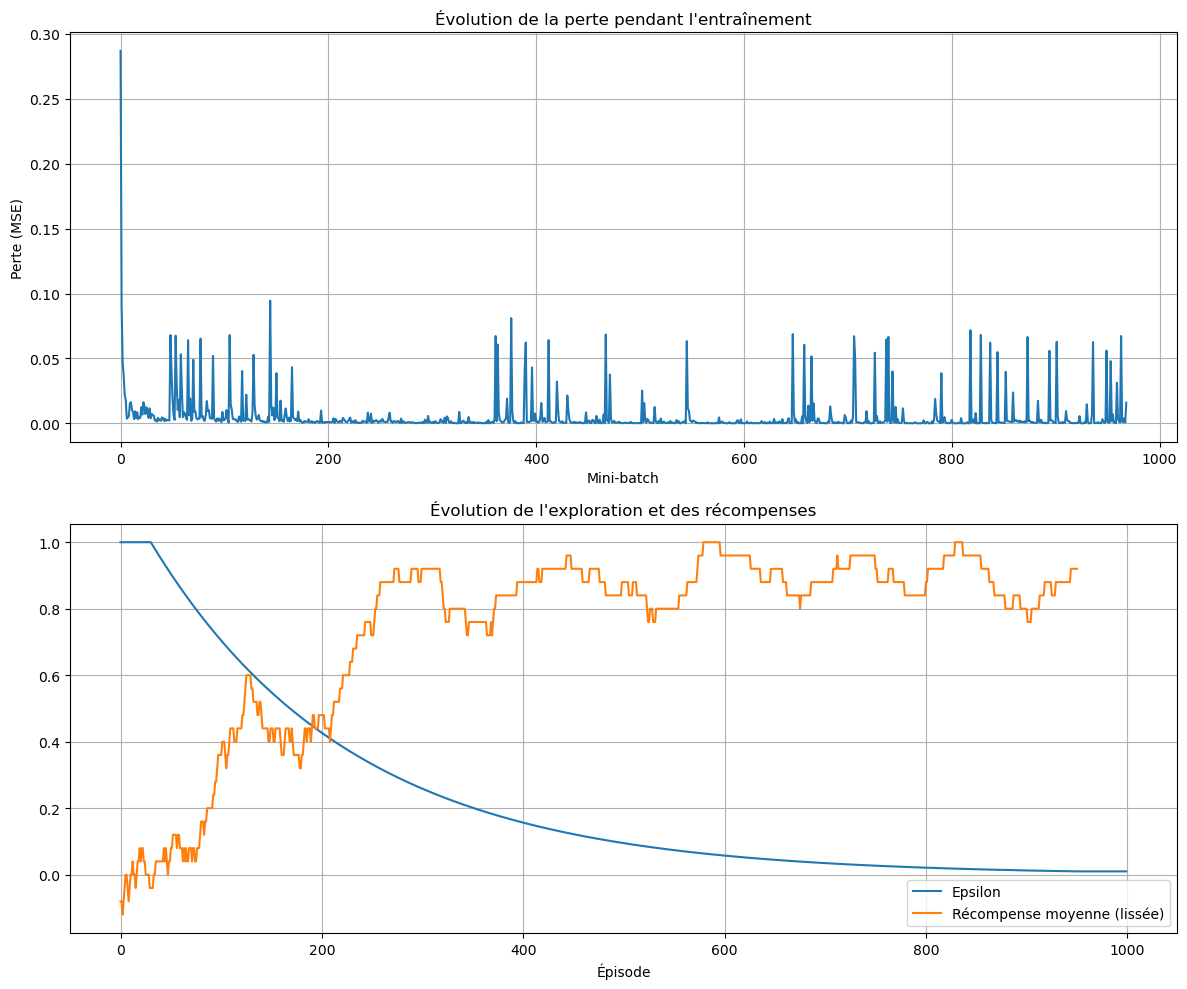

In [29]:
agent.plot_metrics()

Sauvegarde du modèle et du vectoriseur


In [30]:
print("\nSauvegarde du modèle et du vectoriseur...")
agent.save('../app/fake_job_dqn_model.pth')
with open('../app/vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)
print("Sauvegarde terminée!")


Sauvegarde du modèle et du vectoriseur...
Sauvegarde terminée!


Évaluation du modèle sur l'ensemble de test

In [31]:
y_pred = []
q_values_list = []

In [32]:
with torch.no_grad():
    for i in range(len(X_test)):
        state = X_test[i].astype(np.float32)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = agent.model(state_tensor)
        action = torch.argmax(q_values[0]).item()
        y_pred.append(action)
        q_values_list.append(q_values[0].numpy())

Calcul des métriques

In [33]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision: {accuracy:.4f}")
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

Précision: 0.9558

Rapport de classification:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3403
           1       0.69      0.16      0.25       173

    accuracy                           0.96      3576
   macro avg       0.83      0.58      0.62      3576
weighted avg       0.95      0.96      0.94      3576



Matrice de confusion

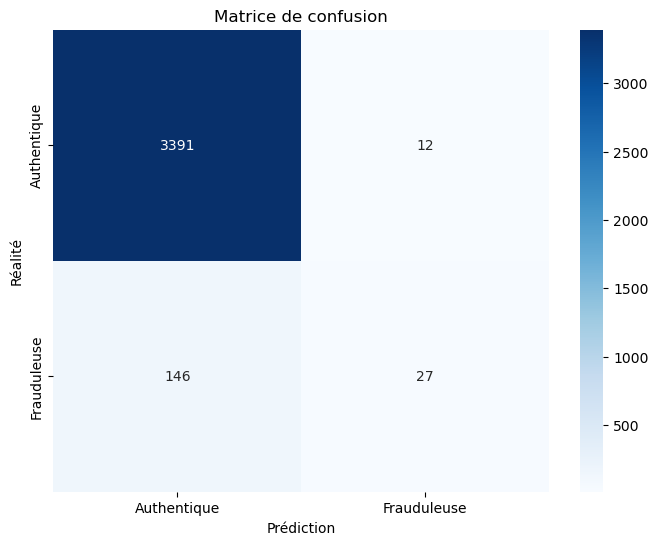

In [34]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Authentique', 'Frauduleuse'],
            yticklabels=['Authentique', 'Frauduleuse'])
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.show()

Visualisation 3D des Q-values

In [35]:
plt.ion()  # Active le mode interactif
sample_size = min(100, len(X_test))  # Limite à 100 exemples pour la visualisation
q_values_sample = np.array(q_values_list[:sample_size])
indices = np.arange(sample_size)
q_real = q_values_sample[:, 0]
q_fake = q_values_sample[:, 1]

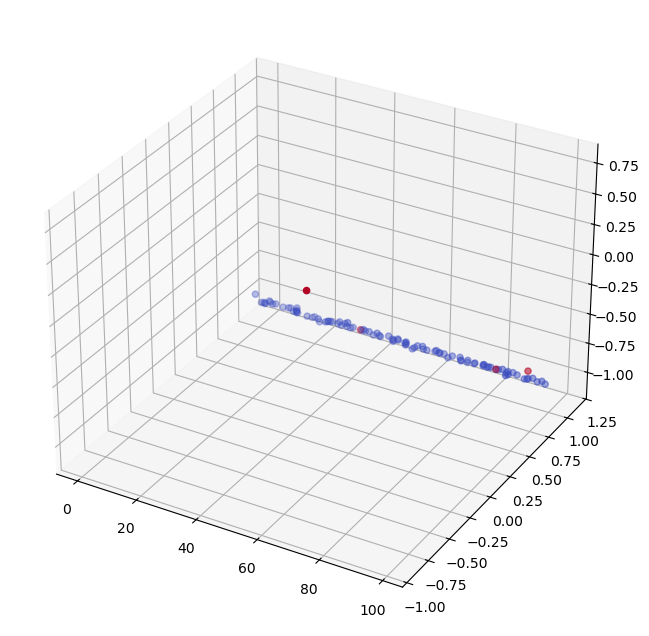

In [36]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(indices, q_real, q_fake, c=y_test[:sample_size], cmap='coolwarm', marker='o')


In [37]:
ax.set_xlabel('Index de l\'échantillon')
ax.set_ylabel('Q-value (Authentique)')
ax.set_zlabel('Q-value (Frauduleuse)')
ax.set_title('Visualisation 3D des Q-values pour les échantillons de test')


Text(0.5, 0.92, 'Visualisation 3D des Q-values pour les échantillons de test')

In [38]:
cbar = plt.colorbar(scatter)
cbar.set_label('Classe (0=Authentique, 1=Frauduleuse)')
plt.show(block=False)  # Affichage non bloquant


C:\Windows\Temp\ipykernel_22432\935497393.py:1: UserWarning: Adding colorbar to a different Figure <Figure size 1000x800 with 2 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(scatter)


<Figure size 640x480 with 0 Axes>

Exercice 4: Test en situation réelle

In [39]:
# Test sur une nouvelle offre d'emploi
new_job = {
    'title': 'Data Scientist - Remote Work',
    'description': 'Exciting opportunity for a Data Scientist to join our team! Must have 3+ years of experience in machine learning and Python. Work from home with competitive salary. Send your CV and bank details for direct payment processing.'
}

In [40]:
print("Nouvelle offre d'emploi:")
print(f"Titre: {new_job['title']}")
print(f"Description: {new_job['description']}")


Nouvelle offre d'emploi:
Titre: Data Scientist - Remote Work
Description: Exciting opportunity for a Data Scientist to join our team! Must have 3+ years of experience in machine learning and Python. Work from home with competitive salary. Send your CV and bank details for direct payment processing.


Prétraitement et vectorisation

In [41]:
new_text = clean_text(new_job['title'] + ' ' + new_job['description'])
new_features = vectorizer.transform([new_text]).toarray().astype(np.float32)


Prédiction

In [42]:
with torch.no_grad():
    state_tensor = torch.FloatTensor(new_features[0]).unsqueeze(0)
    q_values = agent.model(state_tensor)
    prediction = torch.argmax(q_values[0]).item()


In [43]:
print(f"\nPrédiction: {'FRAUDULEUSE' if prediction == 1 else 'AUTHENTIQUE'}")
print(f"Q-values: Authentique: {q_values[0][0].item():.4f}, Frauduleuse: {q_values[0][1].item():.4f}")



Prédiction: AUTHENTIQUE
Q-values: Authentique: 0.9545, Frauduleuse: -0.9517


Visualisation des Q-values pour la nouvelle offre

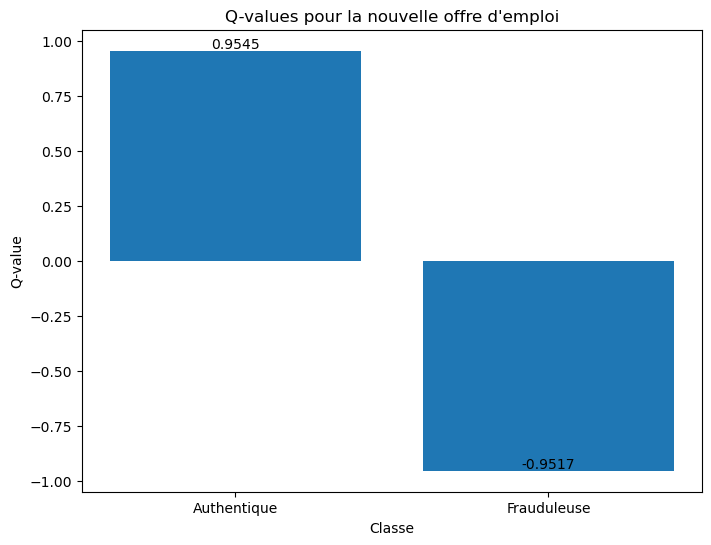

In [44]:
plt.figure(figsize=(8, 6))
classes = ['Authentique', 'Frauduleuse']
plt.bar(classes, q_values[0].numpy())
plt.title('Q-values pour la nouvelle offre d\'emploi')
plt.xlabel('Classe')
plt.ylabel('Q-value')
for i, v in enumerate(q_values[0].numpy()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show(block=False)

Test sur plusieurs offres avec différents niveaux de risque

In [45]:
test_jobs = [
    {
        'title': 'Software Developer - Entry Level',
        'description': 'Join our team as a junior developer. We offer mentorship and training. Requirements: Basic knowledge of programming.'
    },
    {
        'title': 'Marketing Specialist - Work from Home',
        'description': 'Marketing position with flexible hours. Help promote our products online. Experience with social media marketing preferred.'
    },
    {
        'title': 'URGENT - Make Money Fast - Work From Home',
        'description': 'Make $5000 weekly working just 2 hours a day! No experience needed! Just send us your bank details to get started.'
    }
]

In [46]:
for i, job in enumerate(test_jobs):
    text = clean_text(job['title'] + ' ' + job['description'])
    features = vectorizer.transform([text]).toarray().astype(np.float32)
    
    with torch.no_grad():
        state_tensor = torch.FloatTensor(features[0]).unsqueeze(0)
        q_values = agent.model(state_tensor)
        prediction = torch.argmax(q_values[0]).item()
    
    print(f"\nOffre {i+1}:")
    print(f"Titre: {job['title']}")
    print(f"Description: {job['description']}")
    print(f"Prédiction: {'FRAUDULEUSE' if prediction == 1 else 'AUTHENTIQUE'}")
    print(f"Confiance: {abs(q_values[0][0].item() - q_values[0][1].item()):.4f}")



Offre 1:
Titre: Software Developer - Entry Level
Description: Join our team as a junior developer. We offer mentorship and training. Requirements: Basic knowledge of programming.
Prédiction: AUTHENTIQUE
Confiance: 1.9375

Offre 2:
Titre: Marketing Specialist - Work from Home
Description: Marketing position with flexible hours. Help promote our products online. Experience with social media marketing preferred.
Prédiction: AUTHENTIQUE
Confiance: 1.4653

Offre 3:
Titre: URGENT - Make Money Fast - Work From Home
Description: Make $5000 weekly working just 2 hours a day! No experience needed! Just send us your bank details to get started.
Prédiction: AUTHENTIQUE
Confiance: 1.5409
